In [10]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split

In [11]:
'''
Author: Daniel Uvaydov
The following script is used in the 2021 INFOCOM paper:

D. Uvaydov, S. D’Oro, F. Restuccia and T. Melodia,
"DeepSense: Fast Wideband Spectrum Sensing Through Real-Time In-the-Loop Deep Learning,"
IEEE INFOCOM 2021 - IEEE Conference on Computer Communications, 2021.

bin2hdf5.py:
This script converts the raw .bin files collected from GNU Radio to .h5 files to be preprocessed later
'''

# If you desire to plot the spectrogram of the samples set below to True
plot_spect = False

# Getting list of raw .bin files
bin_folder_fp = "data/binary/"               # filepath of folder contain .bin files
bin_folder = os.listdir(bin_folder_fp)      # list of files in folder

# Filepath of folder that will contain the converted h5 files
h5_folder_fp = "data/h5/"
if not os.path.isdir(h5_folder_fp):
    os.mkdir(h5_folder_fp)

# Parameters for training 1D CNN
buf = 256                           # Size of input to CNN in number of I/Q samples, this is necessary since the wave contains multiple frequencies
stride = 16                         # To create overlap between samples (if no overlap desired set stride = buf)"
nsamples_per_file = 50_000           # Number of buf sized training/testing samples to be gathered from each .bin file

# Number of complex values to read from .bin file to generate desired amount of training/testing samples
# If you want to read all the complex values set niq2read = -1
niq2read = (nsamples_per_file-1) * stride + buf

# Number of complex values to skip over before reading
offset = 0

# Iterate through each .bin file and add contents to .h5 file
for file in bin_folder:
    if not os.path.isdir(bin_folder_fp + file):
        with open(bin_folder_fp + file) as binfile:

            # Extract desired number of samples
            samps = np.fromfile(binfile, dtype=np.complex64, count=niq2read, offset=offset)

            # Plot samples
            if plot_spect:
                # Generate spectrogram at sampling rate of 20MHz
                f, t, Sxx = spectrogram(
                    x=samps, 
                    fs=20000000, 
                    return_onesided=False
                )

                # Compensate for FFT Shift caused by GNU Radio
                Sxx = np.fft.fftshift(
                    x=Sxx, 
                    axes=0
                )

                # Plot spectrogram
                # play with vmax to better see certain transmissions
                plt.pcolormesh(t, np.fft.fftshift(f), Sxx, shading='auto', vmax=np.max(Sxx)/100)
                plt.ylabel('Frequency [Hz]')
                plt.xlabel('Time [sec]')
                plt.title(file)
                plt.show()

            # Turn 1D complex array of raw samples and reshape into a 2D array containing I and Q as floats
            # Get real and imaginary parts of samples and stack them together
            samps = np.transpose(np.stack((np.real(samps), np.imag(samps))))

            # Break long 2D array containing all I/Q values into multiple training/testing samples
            samps = np.array([samps[k:k + buf] for k in range(0, len(samps) - 1 - buf, stride)])

            # Create .h5 file with same name as .bin file and fill with reshaped samples
            name = os.path.splitext(file)[0]
            f = h5py.File(h5_folder_fp + name + '.h5', 'w')
            # Create dataset with same name as .bin file
            dset = f.create_dataset(name, (samps.shape[0], samps.shape[1], samps.shape[2]), dtype='float32')
            # Fill dataset with reshaped samples
            dset[()] = samps

            # Print shape
            print(f"File: {name}.h5, Shape: {samps.shape}")
            f.close()

File: 0011_day1.h5, Shape: (49999, 256, 2)
File: 0011_day2.h5, Shape: (49999, 256, 2)
File: 0100_day1.h5, Shape: (49999, 256, 2)
File: 0100_day2.h5, Shape: (49999, 256, 2)
File: 0101_day1.h5, Shape: (49999, 256, 2)
File: 0101_day2.h5, Shape: (49999, 256, 2)
File: 0110_day1.h5, Shape: (49999, 256, 2)
File: 0110_day2.h5, Shape: (49999, 256, 2)
File: 0111_day1.h5, Shape: (49999, 256, 2)
File: 0111_day2.h5, Shape: (49999, 256, 2)
File: 1000_day1.h5, Shape: (49999, 256, 2)
File: 1000_day2.h5, Shape: (49999, 256, 2)
File: 1001_day1.h5, Shape: (49999, 256, 2)
File: 1001_day2.h5, Shape: (49999, 256, 2)
File: 1010_day1.h5, Shape: (49999, 256, 2)
File: 1010_day2.h5, Shape: (49999, 256, 2)
File: 1011_day1.h5, Shape: (49999, 256, 2)
File: 1011_day2.h5, Shape: (49999, 256, 2)
File: 1100_day1.h5, Shape: (49999, 256, 2)
File: 1100_day2.h5, Shape: (49999, 256, 2)
File: 1101_day1.h5, Shape: (49999, 256, 2)
File: 1101_day2.h5, Shape: (49999, 256, 2)
File: 1110_day1.h5, Shape: (49999, 256, 2)
File: 1110_

In [12]:
# Filepath containing directory with converted .h5 files
h5_folder_fp = "data/h5/"
folder = os.listdir(h5_folder_fp)
folder.sort()

# Generate dummy arrays to be contain entire dataset and dataset labels (can also use list and convert to np.array later) (labels are for for channels if occupied or not)
dataset_labels = np.zeros((1, 4))
dataset = np.zeros((1, buf, 2))

for file in folder: 
    if not os.path.isdir(h5_folder_fp + file):
        # Open .h5 file
        f = h5py.File(h5_folder_fp + file, 'r')
        # Get label from filename
        name = os.path.splitext(file)[0]
        # Get data from file
        data = f[name][()]

        # Append samples from current file to dataset
        dataset = np.concatenate((dataset, data))

        # Generates the multi-hot encoded labels from the file name
        label = list(name.split('_')[0])    # Take part of filename that contains labels
        label = list(map(int, label))       # Convert string to multi-hot list
        label = [label] * data.shape[0]     # Generate label for each training sample in file
        label = np.array(label, dtype='i')  # Convert list of labels to np.array
        dataset_labels = np.concatenate((dataset_labels, label))    # Append to labels for entire dataset

f.close()

# Delete first entry of arrays as they contain zeros
dataset = np.delete(dataset, 0, 0)
dataset_labels = np.delete(dataset_labels, 0, 0)

print(dataset.shape)
print(dataset_labels.shape)

(1599968, 256, 2)
(1599968, 4)


In [13]:
# Shuffle dataset and split into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(
    dataset, 
    dataset_labels, 
    test_size=0.1, 
    random_state=42
)

# Print shapes of training and testing samples
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1439971, 256, 2)
y_train shape:  (1439971, 4)
X_test shape:  (159997, 256, 2)
y_test shape:  (159997, 4)


# Data exploration

In [14]:
print('Sample of training set:')
print(X_train[0])
print('Label of training set:')
print(y_train[0])

Sample of training set:
[[-0.02081355 -0.05883947]
 [-0.02069147 -0.05844273]
 [-0.01986748 -0.05816806]
 [-0.01919607 -0.05825962]
 [-0.01925711 -0.0578934 ]
 [-0.02059992 -0.05844273]
 [-0.0212408  -0.05883947]
 [-0.02072199 -0.05954139]
 [-0.02072199 -0.05896154]
 [-0.0200811  -0.05810703]
 [-0.01992851 -0.05725251]
 [-0.01977592 -0.05722199]
 [-0.01937918 -0.05767977]
 [-0.01956229 -0.05874791]
 [-0.02047784 -0.05911414]
 [-0.02194273 -0.05935828]
 [-0.02151547 -0.05899206]
 [-0.02038629 -0.05804599]
 [-0.01934866 -0.0574051 ]
 [-0.01928763 -0.05737459]
 [-0.0194097  -0.05728303]
 [-0.01962333 -0.05890051]
 [-0.02069147 -0.05932776]
 [-0.02145443 -0.05926673]
 [-0.02087458 -0.05929724]
 [-0.02020318 -0.05874791]
 [-0.01916555 -0.05813755]
 [-0.01947074 -0.05835117]
 [-0.01998955 -0.05804599]
 [-0.02044732 -0.0578934 ]
 [-0.02072199 -0.05865636]
 [-0.02084406 -0.0597245 ]
 [-0.0202337  -0.05969398]
 [-0.01931814 -0.05883947]
 [-0.01840259 -0.05801547]
 [-0.01895192 -0.05743562]
 [-0

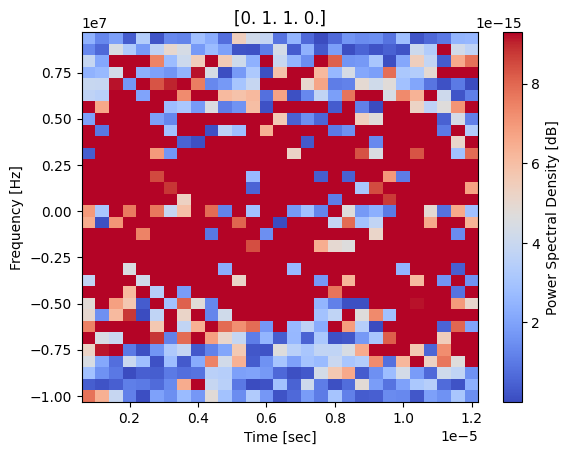

Channels: [0.03062172 0.44812298 0.48512983 0.03612547]
Label: [0. 1. 1. 0.]
Shape: (32, 29)


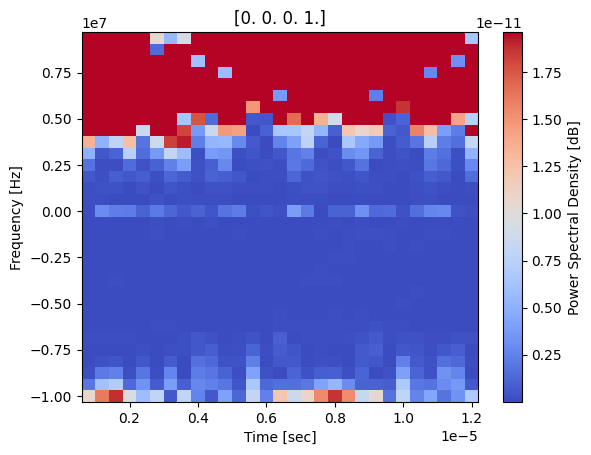

Channels: [5.59934501e-03 1.23072248e-04 1.02021449e-02 9.84075438e-01]
Label: [0. 0. 0. 1.]
Shape: (32, 29)


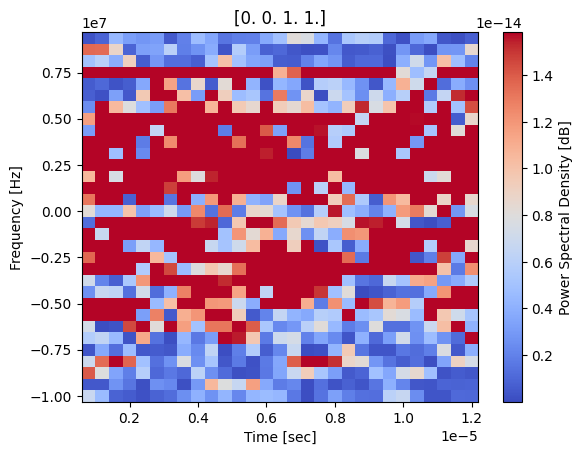

Channels: [0.02928202 0.10911969 0.79541832 0.06617997]
Label: [0. 0. 1. 1.]
Shape: (32, 29)


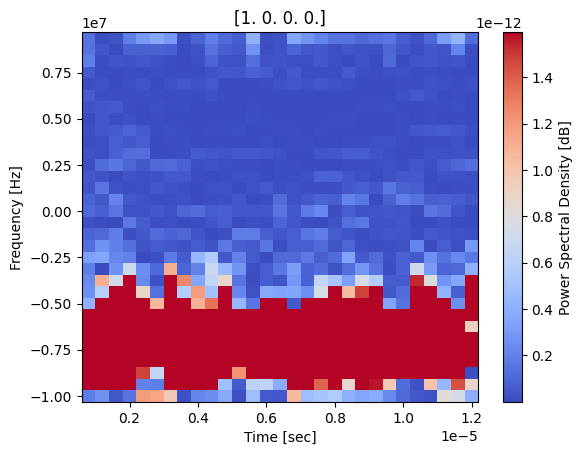

Channels: [0.96612657 0.03039915 0.0016902  0.00178407]
Label: [1. 0. 0. 0.]
Shape: (32, 29)


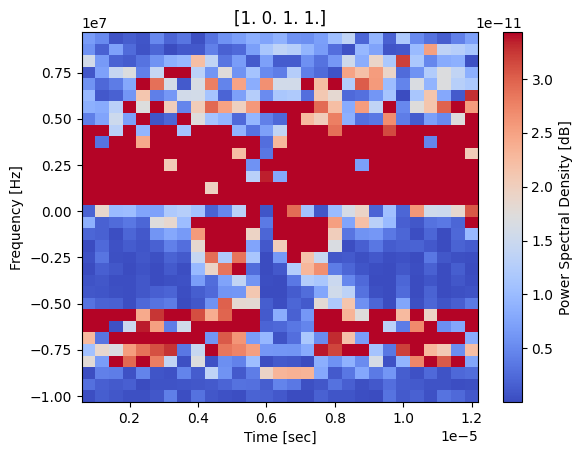

Channels: [0.05475238 0.04205349 0.86723633 0.0359578 ]
Label: [1. 0. 1. 1.]
Shape: (32, 29)


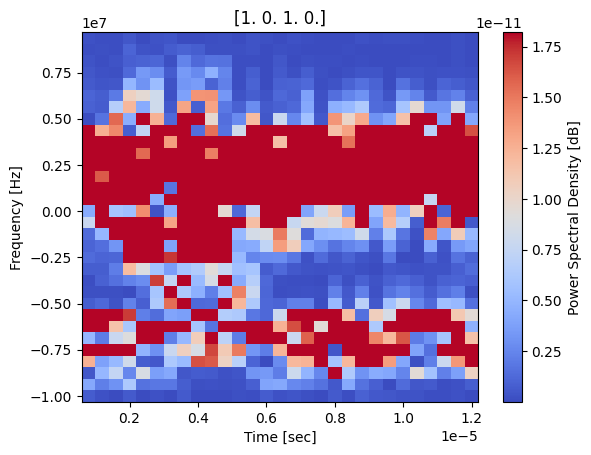

Channels: [0.0525897  0.05770253 0.88066391 0.00904386]
Label: [1. 0. 1. 0.]
Shape: (32, 29)


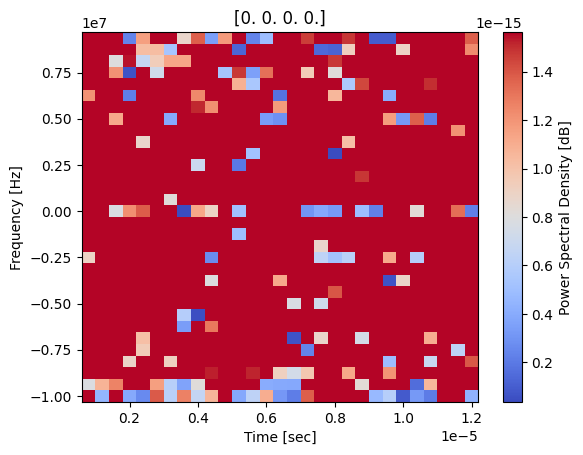

Channels: [0.10262688 0.42095291 0.36724955 0.10917067]
Label: [0. 0. 0. 0.]
Shape: (32, 29)


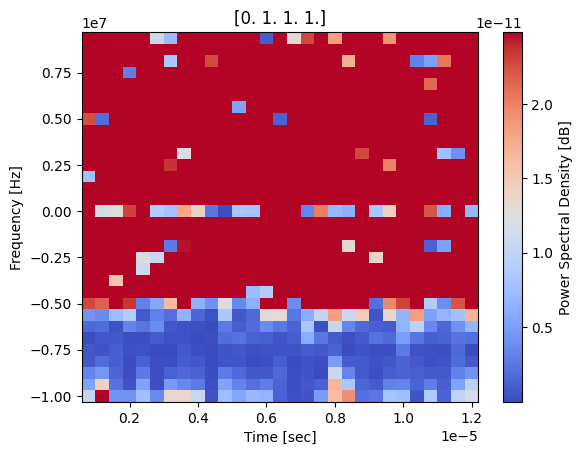

Channels: [0.00325165 0.23495911 0.4500301  0.31175915]
Label: [0. 1. 1. 1.]
Shape: (32, 29)


In [15]:
for sam_i in range(8):
    # Define parameters
    real_signal = X_train[sam_i, :, 0] # Shape: (128,1) so array of 128 real values
    imag_signal = X_train[sam_i, :, 1] # Shape: (128,1) so array of 128 imaginary values

    # Combine real and imaginary parts to form a complex signal 1D array
    complex_signal = real_signal + 1j * imag_signal

    # Generate spectrogram at sampling rate of 20MHz
    f, t, Sxx = spectrogram(
        x=complex_signal,
        fs=20000000,
        nperseg=32,
        noverlap=24,
        return_onesided=False
    )

    # Compensate for FFT Shift caused by GNU Radio
    Sxx = np.fft.fftshift(
        x=Sxx, 
        axes=0
    )
    f = np.fft.fftshift(f)

    if plot_spect or True:
        # Plot spectrogram
        plt.pcolormesh(t, f, Sxx, shading='auto', vmax=np.max(Sxx)/100, cmap='coolwarm')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.colorbar(label='Power Spectral Density [dB]')
        plt.title(y_train[sam_i])
        plt.show()

    # Get the signal strength over 4 channels
    channel_size = len(f) // 4
    channels = np.zeros(4)

    for i in range(4):
        channel_num = i + 1

        # Combine all the frequencies in the channel
        channel_strength = Sxx[i*channel_size:(i+1)*channel_size]
        # Sum all values in the channel to get occupancy of channel
        channel_strength = np.sum(channel_strength)
        # Make values from 0 to 1 on relative scale to each other
        channel_strength = channel_strength / np.sum(Sxx)

        channels[i] = channel_strength

    print(f'Channels: {channels}')
    print(f'Label: {y_train[sam_i]}')
    print(f'Shape: {Sxx.shape}')

# Generating data

In [16]:
def generate_dataset(data):
    result = None

    for sam_i in range(data.shape[0]):
        sys.stdout.write(f'\rProcessing sample {sam_i+1}/{data.shape[0]}')

        # Define parameters
        real_signal = data[sam_i, :, 0] # Shape: (128,1) so array of 128 real values
        imag_signal = data[sam_i, :, 1] # Shape: (128,1) so array of 128 imaginary values

        # Combine real and imaginary parts to form a complex signal 1D array
        complex_signal = real_signal + 1j * imag_signal

        # Generate spectrogram at sampling rate of 20MHz
        f, t, Sxx = spectrogram(
            x=complex_signal,
            fs=20000000,
            nperseg=32,
            noverlap=24,
            return_onesided=False
        )

        # Compensate for FFT Shift caused by GNU Radio
        Sxx = np.fft.fftshift(
            x=Sxx, 
            axes=0
        )
        f = np.fft.fftshift(f)

        if plot_spect:
            # Plot spectrogram
            plt.pcolormesh(t, f, Sxx, shading='auto', vmax=np.max(Sxx)/100, cmap='coolwarm')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.colorbar(label='Power Spectral Density [dB]')
            plt.title(y_train[sam_i])
            plt.show()

        # Get the signal strength over 4 channels
        channel_size = len(f) // 4
        channels = np.zeros((4, len(t)))

        for i in range(4):
            # Combine all the frequencies in the channel
            channel_strength = Sxx[i*channel_size:(i+1)*channel_size]

            # Change from (15, 8) to (1, 8) by summing over the frequency axis
            channel_strength = np.sum(channel_strength, axis=0)

            # Save the channel strength to correct channel
            channels[i] = channel_strength

        # Average out channels between 0 and 1
        for n in range(channels.shape[1]):
            channels[:, n] = channels[:, n] / np.sum(channels[:, n])

        if result is None:
            result = np.zeros((data.shape[0], 4, len(t)))
        
        result[sam_i] = channels

    return result

In [17]:
X_train = generate_dataset(X_train)
print(X_train.shape)
X_test = generate_dataset(X_test)
print(X_test.shape)

Processing sample 1439971/1439971(1439971, 4, 29)
Processing sample 159997/159997(159997, 4, 29)


In [ ]:
# Save test set
f_test = h5py.File('data/sdr_wifi_test.hdf5', 'w')
xtest = f_test.create_dataset('X', (X_test.shape[0], X_test.shape[1], X_test.shape[2]), dtype='f')
ytest = f_test.create_dataset('y', (y_test.shape[0], y_test.shape[1]), dtype='i')
xtest[()] = X_test
ytest[()] = y_test
f_test.close()

# Save train set
f_train = h5py.File('data/sdr_wifi_train.hdf5', 'w')
xtrain = f_train.create_dataset('X', (X_train.shape[0], X_train.shape[1], X_train.shape[2]), dtype='f')
ytrain = f_train.create_dataset('y', (y_train.shape[0], y_train.shape[1]), dtype='i')
xtrain[()] = X_train
ytrain[()] = y_train
f_train.close()